# 矩阵方法实现光学薄膜计算

### 导入库

In [1]:
import math
from cmath import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib 魔法命令
%matplotlib notebook

### 全局变量

In [2]:
global n_0 ,n_b ,theta_0 ,eta_0 ,eta_s
n_0 = 1
n_s = 1.5

## 理论基础：膜系矩阵方程

$$
\large E_{_0}\begin{bmatrix}
    1\\
    Y
\end{bmatrix}=\left\{\prod_{j=1}^{K}\begin{bmatrix}
    \cos{\delta_j} & \frac{i}{\widetilde{\zeta}_j}\sin{\delta_j}\\
    i\widetilde{\zeta}_j\sin{\delta_j} & \cos{\delta_j}
\end{bmatrix}\right\}\begin{bmatrix}
1\\
\widetilde{\zeta}_{_G}
\end{bmatrix}E_{_K+1}
$$

### 修正导纳

* $s$ 光：$\widetilde{\zeta}_j=N_j\cos\theta_j$

* $p$ 光：$\widetilde{\zeta}_j=\frac{N_j}{\cos{\theta}_j}$

In [3]:
def eta_s_p(n ,theta ,mode):
    if mode == 'p':
        eta = n / cos(theta)
    else:
        eta = n * cos(theta)
    return eta

### 薄膜特征矩阵

$$
\begin{bmatrix}
    \cos{\delta_j} & \frac{i}{\widetilde{\zeta}_j}\sin{\delta_j}\\
    i\widetilde{\zeta}_j\sin{\delta_j} & \cos{\delta_j}
\end{bmatrix}
$$

In [4]:
def M_matrix(n_d_data ,wavelength ,mode):
    M_e = np.eye(2,2)
    for row in n_d_data.itertuples():
        theta = asin(n_0 * sin(theta_0)/row[1])
        delta = 2 * pi/wavelength * row[2] * cos(theta)
        eta = eta_s_p(row[1] ,theta ,mode)
        M_e = M_e @ np.array([[cos(delta)       ,1j * sin(delta)/eta],
                              [1j * eta * sin(delta)    ,cos(delta)]])
    return M_e

### 膜系特征向量

$$
\begin{bmatrix}
    B\\
    C
\end{bmatrix}=\left\{\prod\limits_{j=1}^{K}\begin{bmatrix}
    \cos{\delta_j} & \frac{i}{\widetilde{\zeta}_j}\sin{\delta_j}\\
    i\widetilde{\zeta}_j\sin{\delta_j} & \cos{\delta_j}
\end{bmatrix}\right\}\begin{bmatrix}
    1\\
    \widetilde{\zeta}_{_G}
\end{bmatrix}
$$

In [5]:
def v_vector(n_d_data ,wavelength ,mode):
    M_e = M_matrix(n_d_data ,wavelength ,mode)
    v_e = M_e @ np.array([[1] ,
                          [eta_s]])
    return v_e

### 物理量计算 

**组合导纳**

$$
Y=\frac{C}{B}
$$

**反射率**

$$
\begin{aligned}
    r&=\frac{\widetilde{\zeta}_{_0}-Y}{\widetilde{\zeta}_{_0}+Y}\\
    R&=\widetilde{r}\widetilde{r}^*=\left(\frac{\widetilde{\zeta}_0B-C}{\widetilde{\zeta}_0B-C}\right)\left(\frac{\widetilde{\zeta}_0B-C}{\widetilde{\zeta}_0B-C}\right)^*
\end{aligned}
$$

**透射率**

$$
T=\frac{4\operatorname{Re}[\widetilde{\zeta}_{_0}\widetilde{\zeta}_{_G}]}{(\widetilde{\zeta}_0 B+C)(\widetilde{\zeta}_0 B+C)^*}
$$

**吸收率**

$$
A=1-R-T
$$

In [6]:
def calculate(v_e):
    B = v_e[0] ;C = v_e[1] 
    Y = C/B
    r = (eta_0 - Y)/(eta_0 + Y)
    R = (abs(r)**2).real
    T = (4 * (eta_0 * eta_s).real/(abs(eta_0 * B + C)**2)).real
    A = (1 - R -T).real
    return (R ,T ,A)    

## 计算举例

### （一）单层膜反射率随光学厚度变化曲线

#### 参数设置

In [7]:
# 参考波长
wavelength = 400
# 折射率设置
n_list = [1.1,1.22,1.3,1.4,1.5,1.6,1.7,1.8]
# 光学厚度设置
nd_list = np.linspace(100,900,800)
# s光 or p光
mode = 's'

#### 实现

<IPython.core.display.Javascript object>


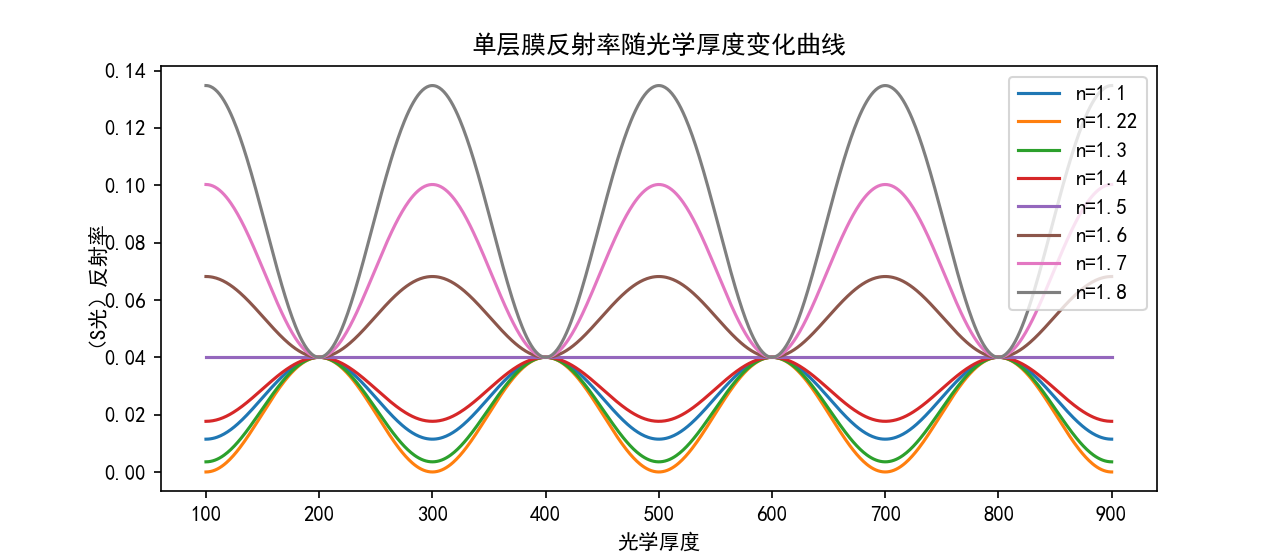

In [8]:
# 入射角
theta_0 = 0
# 入射介质导纳
eta_0 = eta_s_p(n_0 ,theta_0 ,mode)
# 基底导纳
theta_s = asin(n_0 * sin(theta_0)/n_s)
eta_s = eta_s_p(n_s ,theta_s ,mode)

plt.figure(1) 
for n in n_list:
    R_list = []
    for nd in nd_list:
        # 手动生成单层膜数据框
        n_d_data = pd.DataFrame({'折射率':[n] ,'光学厚度':[nd]})
        v_e = v_vector(n_d_data ,wavelength ,mode)
        (R ,T ,A) = calculate(v_e)       
        R_list.append(R)
    R_list = np.array(R_list)
    plt.plot(nd_list ,R_list ,label = 'n=' + str(n))
plt.xlabel('光学厚度') ;plt.ylabel('（S光）反射率')
plt.title('单层膜反射率随光学厚度变化曲线')
plt.legend(loc = 'best')
plt.show()

### 看图说话

为方便讨论，引入 $\lambda/4$ 膜，即

$$
nd\cos\theta=m\frac{\lambda}{4}
$$

**$m$ 为奇数（$\lambda/4膜层$）**，为反射率极值点

$$
R=\left(\frac{n_0-Y}{n_0+Y}\right)^2=\left(\frac{n_0-\frac{n_1^2}{n_{_G}}}{n_0+\frac{n_1^2}{n_{_G}}}\right)^2
$$

**$m$ 为偶数（$\lambda/2膜层$）**，为“虚设层”（反射率与膜层折射率无关），

$$
R=\left(\frac{n_0-n_{_G}}{n_0+n_{_G}}\right)^2
$$

**$n>n_{_G}$，为增反膜**，并且有效光学厚度为 $\lambda/4$ 奇数倍时，反射率达到极大值

**$n<n_{_G}$，为增透膜**，并且有效光学厚度为 $\lambda/4$ 奇数倍时，反射率达到极小值

**$n=n_0 或 n=n_{_G}$，膜层不存在**

**对于 $\lambda/4$ 膜层，当膜层折射率满足 $n=\sqrt{n_{_0}n_{_G}}$，反射率 $R$ 为零**

### （二）[HL]$^m$周期多层膜

#### 参数设置

In [9]:
# 入射光波长范围
lambda_s = 350 ;lambda_e = 500
num_lambda = 500
lambda_list = np.linspace(lambda_s ,lambda_e ,num_lambda)
# 导入膜系数据框
n_d_data_1 = pd.read_excel('data.xlsx' ,'Sheet1')
n_d_data_2 = pd.read_excel('data.xlsx' ,'Sheet2')
n_d_data_3 = pd.read_excel('data.xlsx' ,'Sheet3')
# s光 or p光
mode = 's'
# 入射角
theta_0 = 0
# 入射介质导纳
eta_0 = eta_s_p(n_0 ,theta_0 ,mode)
# 基底导纳
theta_s = asin(n_0 * sin(theta_0)/n_s)
eta_s = eta_s_p(n_s ,theta_s ,mode)

#### 实现（波长 - 反射率）

<IPython.core.display.Javascript object>


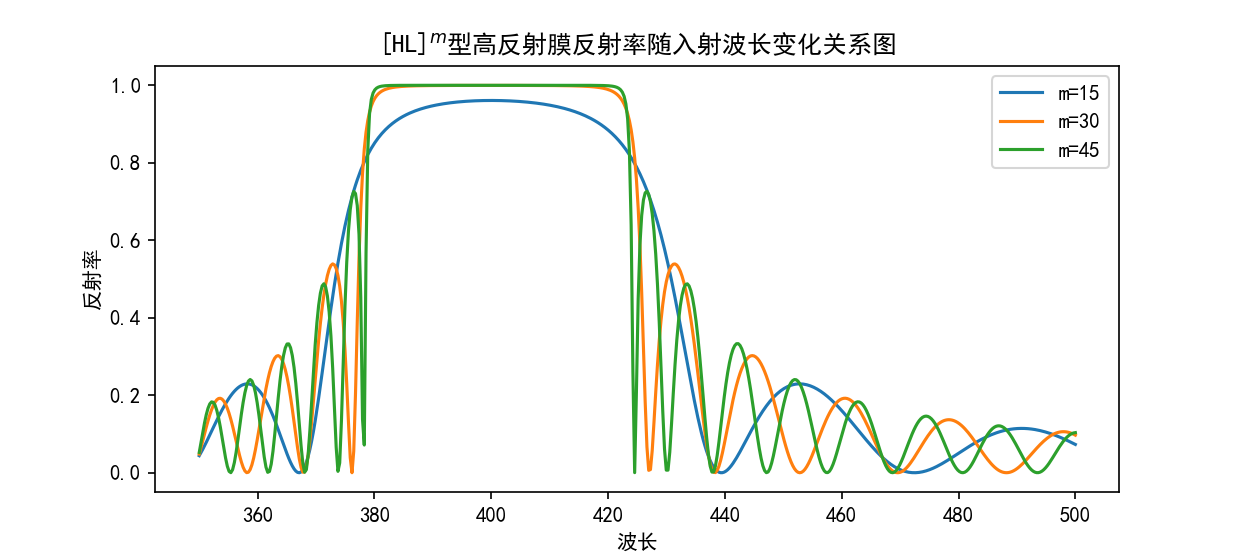

In [10]:
plt.figure(2)
for (n_d_data ,m) in [(n_d_data_1 ,15) ,(n_d_data_2 ,30) ,(n_d_data_3 ,45)]:
    R_list = []
    for wavelength in lambda_list:
        v_e = v_vector(n_d_data ,wavelength ,mode)
        (R ,T ,A)= calculate(v_e)
        R_list.append(R)
    R_list = np.array(R_list)
    plt.plot(lambda_list ,R_list ,label ='m='+ str(m))
plt.xlabel('波长') ;plt.ylabel('反射率')
plt.title('[HL]$^{m}$型高反射膜反射率随入射波长变化关系图')
plt.legend(loc = 'best')
plt.show()

从图中可以看出

* 存在一段反射率近似为 1 的高反射带
* 随着周期数 $m$ 的增大，高反带边缘越接近垂直（拐点波长越明显），高反带外波纹振荡数目增加


#### 实现（波长 - 相对波数）

<IPython.core.display.Javascript object>


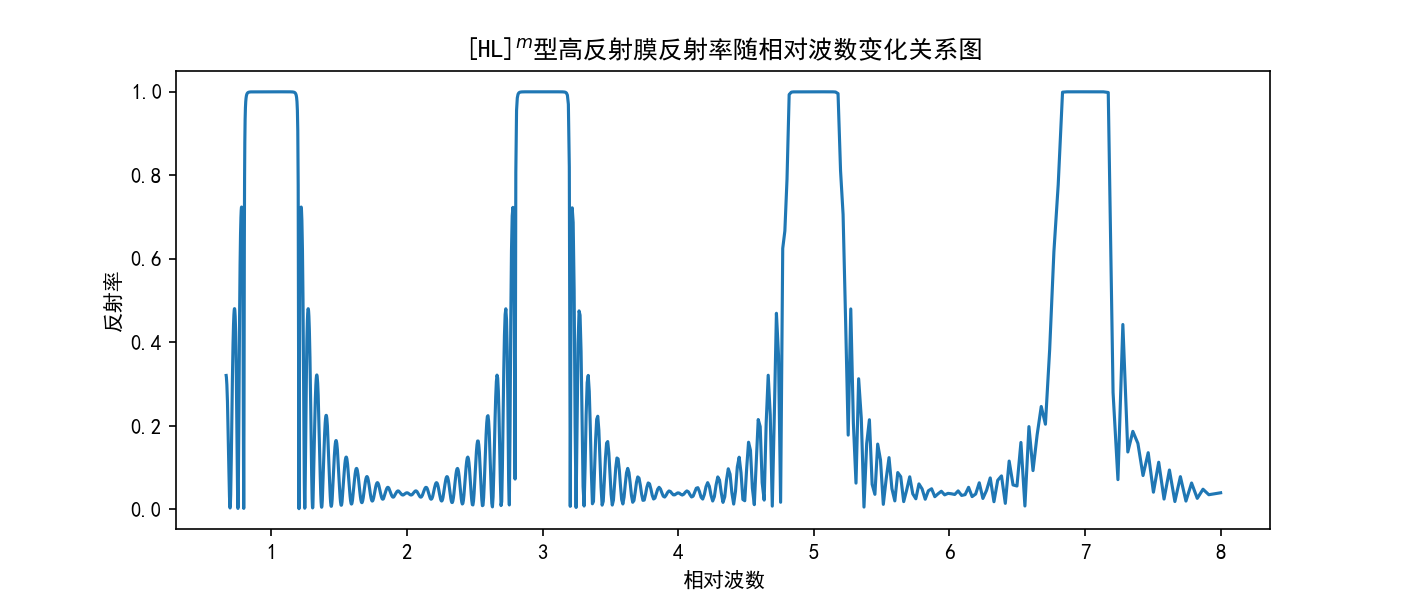

In [11]:
lambda_s = 50 ;lambda_e = 600
num_lambda = 2000
lambda_list = np.linspace(lambda_s ,lambda_e ,num_lambda)
g_list = 400/lambda_list
n_d_data = pd.read_excel('data.xlsx' ,'Sheet4')
plt.figure(3)
R_list = []
for wavelength in lambda_list:
    v_e = v_vector(n_d_data ,wavelength ,mode)
    (R ,T ,A)= calculate(v_e)
    R_list.append(R)
R_list = np.array(R_list)
plt.plot(g_list ,R_list)
plt.xlabel('相对波数') ;plt.ylabel('反射率')
plt.title('[HL]$^{m}$型高反射膜反射率随相对波数变化关系图')
plt.show()

### 看图说话

**高反带与高透带**

$$
\begin{cases}
    g<1波段\Rightarrow不再有高反带出现\\
    g>1波段\Rightarrow高透、高反带周期性间隔出现
\end{cases}
$$

**高反带与高透带中心**

* 高反带中心 $g=1,3,5\cdots$
* 高透带中心 $g=2,4,6\cdots$

**高反区半宽度**

$$
\Delta g=\frac{2}{\pi}\arcsin\left(\frac{n_H-n_L}{n_H+n_L}\right)
$$

* 所有高反带的波数宽度相等，波数宽度仅与两种膜料折射率差值有关
* $\Delta \lambda=\frac{\lambda^2}{\lambda_0}\Delta g$，各高反带波长宽度不相等，波数越大，波长宽度越窄

*注意*：垂直入射时，（s光，p光）波数宽度无差别，斜入射时则不相等

### 高反射膜与周期多层膜系

利用周期多层膜系制成的高反射膜可使反射率 $R>99\%$，且具有较宽的带宽。要达到这样高的反射率，单层膜是无法实现的，通常采用光学厚度均为 $\lambda/4$ 的高、低折射率交替排列构成的周期性多层膜，以下是常见的高反射膜系结构

* A | (HL)$^m$ | G $\hspace{0.5cm}\rightarrow Y=\left(\frac{n_H}{n_L}\right)^{2m}n_{_G}$

* A | (HL)$^m$H | G $\hspace{0.5cm}\rightarrow Y=\left(\frac{n_H}{n_L}\right)^{2m}\frac{n_H^2}{n_{_G}}$

* A | (LH)$^m$ | G $\hspace{0.5cm}\rightarrow Y=\left(\frac{n_L}{n_H}\right)^{2m}n_{_G}$

* A | (LH)$^m$L | G $\hspace{0.5cm}\rightarrow Y=\left(\frac{n_L}{n_H}\right)^{2m}\frac{n_L^2}{n_{_G}}$

$$
\begin{aligned}
  &R=\widetilde{r}\widetilde{r}^*=\left(\frac{n_0-Y}{n_0+Y}\right)^2\\
  &n_{_H}>n_{_L}，m \to \infty，R \to 1
\end{aligned}
$$

## 周期多层膜系理论

周期多层膜系由两种均匀介质膜层周期性排列构成，其周期性条件表示为

$$
n(z)=n(z+h)
$$

其中 $h$ 为一个周期两膜层的总厚度，假设单周期膜层特征矩阵为

$$
\boldsymbol{Q}(h)=\begin{bmatrix}
  q_{11}&q_{12}\\
  q_{21}&q_{22}
\end{bmatrix}
$$

则 $m$ 个周期构成的膜系特征矩阵为

$$
\boldsymbol{Q}(mh)=\begin{bmatrix}
  Q_{11}&Q_{12}\\
  Q_{21}&Q_{22}
\end{bmatrix}=[\boldsymbol{Q}(h)]^m
$$

如果特征矩阵 $\boldsymbol{Q}(h)$ 的行列式取单位值，根据矩阵论 ~~（研究生阶段的一门课程，不关线性代数的事）~~

$$
\begin{aligned}
  \boldsymbol{Q}(mh)&=\begin{bmatrix}
    q_{11}U_{m-1}(a)-U_{m-2}(a)&q_{12}U_{m-1}(a)\\
    q_{21}U_{m-1}(a)&q_{22}U_{m-1}(a)-U_{m-2}(a)
  \end{bmatrix}\\
  U_m(x)&=\frac{\sin[(m+1)\arccos x]}{\sqrt{1-x^2}}，|x|\leqslant1（第二类切比雪夫多项式）\\
  a&=\frac{1}{2}(q_{11}+q_{22})
\end{aligned}
$$

也就是说膜系特征矩阵的元素 $Q_{11}$、$Q_{12}$、$Q_{21}$、$Q_{22}$ 与切比雪夫多项式的取值相关，切比雪夫多项式的取值由 $a$ 决定，$a$ 的变化（$n_{_L}$ 与 $n_{_H}$ 的变化，相对波数 $g$ 的变化）特点将会反映出膜系反射率的变换特点。对于 [HL]$^m$ 类型的周期多层膜其变换特点已在上面图像中显示。